In [ ]:
import cv2
import os
import pandas as pd
import numpy as np

DATASET_DIR = 'datasetet'
IMG_WIDTH, IMG_HEIGHT = 160, 120

df_balanced = pd.read_csv("dataset/labels_balanced.csv")

images = []
labels = []

for _, row in df_balanced.iterrows():
    frame_id = f"{int(row['frame_id']):06d}.png"
    img_path = os.path.join(DATASET_DIR, 'images', frame_id)

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0  # Normalizar [0,1]
        images.append(img)
        labels.append([row['steer'], row['throttle'], row['brake']])

X = np.array(images, dtype=np.float32)
y = np.array(labels, dtype=np.float32)

print(f"Datos cargados tras balanceo: {X.shape}, {y.shape}")


Datos cargados tras balanceo: (8472, 120, 160, 3), (8472, 3)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Porcentajes de partición
TEST_SIZE = 0.1       # 10% test
VAL_SIZE = 0.15        # 15% validación (del total)

# Separar TEST
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42
)

# Separar VALIDACIÓN del resto (proporcionalmente)
val_rel = VAL_SIZE / (1 - TEST_SIZE)  # fracción relativa de lo que queda
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_rel, random_state=42
)

print(f"Train: {len(X_train)} muestras")
print(f"Val:   {len(X_val)} muestras")
print(f"Test:  {len(X_test)} muestras")


Split final ->
  Train: (5930, 120, 160, 3), (5930, 3)
  Val:   (1271, 120, 160, 3),   (1271, 3)
  Test:  (1271, 120, 160, 3),  (1271, 3)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def build_pilotnet(input_shape=(120, 160, 3), n_outputs=3, l2=1e-4, dropout=0.2):
    reg = tf.keras.regularizers.l2(l2) if l2 and l2 > 0 else None
    kw  = dict(kernel_initializer="he_normal", kernel_regularizer=reg)

    inputs = layers.Input(shape=input_shape)

    # Convolucional (estilo NVIDIA PilotNet)
    x = layers.Conv2D(24, 5, strides=2, activation='relu', **kw)(inputs)
    x = layers.Conv2D(36, 5, strides=2, activation='relu', **kw)(x)
    x = layers.Conv2D(48, 5, strides=2, activation='relu', **kw)(x)
    x = layers.Conv2D(64, 3, strides=1, activation='relu', **kw)(x)
    x = layers.Conv2D(64, 3, strides=1, activation='relu', **kw)(x)

    x = layers.Flatten()(x)

    # Cabezal denso
    x = layers.Dense(100, activation='relu', **kw)(x)
    if dropout and dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(50, activation='relu', **kw)(x)
    x = layers.Dense(10, activation='relu', **kw)(x)

    outputs = layers.Dense(n_outputs, activation='linear', name='controls')(x)

    model = models.Model(inputs, outputs, name="PilotNet_120x160x3")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

model = build_pilotnet(input_shape=(120, 160, 3), n_outputs=3, l2=1e-4, dropout=0.2)
model.summary()

# Entrenamiento
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluación
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Val Loss (MSE): {val_loss:.5f} | Val MAE (promedio 3 salidas): {val_mae:.5f}")

2025-11-10 20:27:19.376192: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 20:27:19.425837: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 20:27:20.832009: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 20:27:21.415090: E external/local_xla/xla/stream_executor/cuda/cuda_p

Model: "PilotNet_120x160x3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 58, 78, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 37, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 17, 48)     │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 15, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 13, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ controls (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 802,641 (3.06 MB)

 Trainable params: 802,641 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.2182 - mae: 0.2815 - val_loss: 0.1958 - val_mae: 0.2717 - learning_rate: 1.0000e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.1885 - mae: 0.2673 - val_loss: 0.1756 - val_mae: 0.2576 - learning_rate: 1.0000e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.1698 - mae: 0.2526 - val_loss: 0.1609 - val_mae: 0.2451 - learning_rate: 1.0000e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.1550 - mae: 0.2395 - val_loss: 0.1475 - val_mae: 0.2320 - learning_rate: 1.0000e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.1413 - mae: 0.2250 - val_loss: 0.1360 - val_mae: 0.2236 - learning_rate: 1.0000e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.1305 - mae: 0.2129 - val_loss: 0.1273 - val_mae: 0.2116 - learning_rate: 1.0000e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.1203 - mae: 0.2014 - val_loss: 0.1189 - val_mae: 0.2026 - lea

In [6]:
y_pred = model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


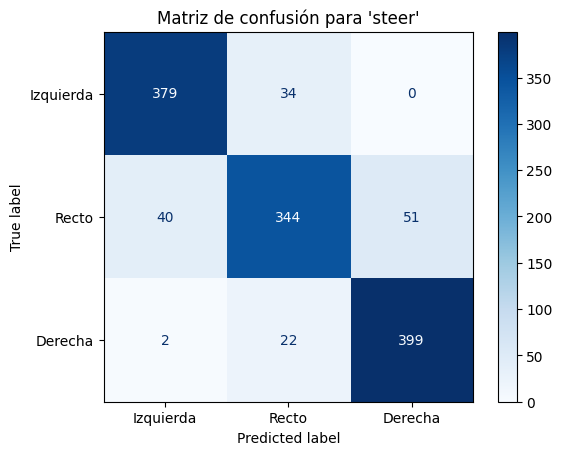

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import numpy as np

def steer_to_class(steer):
    if steer < -0.25:
        return 0  # izquierda
    elif steer > 0.25:
        return 2  # derecha
    else:
        return 1  # recto


y_true_class = np.array([steer_to_class(s) for s in y_test[:, 0]])
y_pred_class = np.array([steer_to_class(s) for s in y_pred[:, 0]])

cm = confusion_matrix(y_true_class, y_pred_class, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Izquierda","Recto","Derecha"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión para 'steer'")
plt.show()

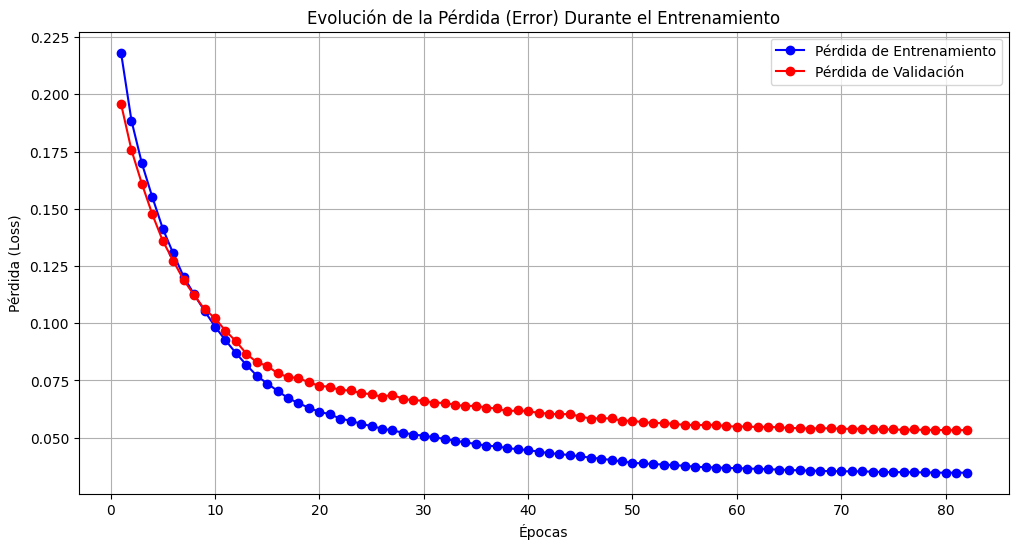

In [8]:
import matplotlib.pyplot as plt

# El historial de tu último entrenamiento está en la variable 'h_cnn'
history_dict = history.history

# Extraer los valores de pérdida (error)
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Crear un rango de épocas para el eje X
epochs_range = range(1, len(loss) + 1)

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, loss, 'b-o', label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, 'r-o', label='Pérdida de Validación')
plt.title('Evolución de la Pérdida (Error) Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.show() # Usamos plt.show() para que se muestre en tu notebook

In [ ]:
model.save('dataset/models/PilotNet_Dataset.h5')

: 